Thanks for this opportunity to be part of this data challenge. My name is Saeed Saberi, PhD. 
Dave Edmunds From MatchBox has introduced me to you and told me about the machine learning position. I welcome the chance to meet and further discuss this position.

I have implemented a neural network with one LSTM memory and one hidden layer. Then I have tried to optimize the network and choose the best hyper parameters. It is important to mention that with more processing power and time one can more aggressively analyze the data, optimize for the parameters with a wider grid search to optimize these parameters. This analysis presented here, has taken 3 days!


# Building the model
Here I am importing the necessary libraries and data necessary for the future analysis:

In [ ]:
import numpy as np
import pandas as pd
import scipy as sc
import matplotlib.pyplot as plt
import seaborn as sns

import math
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import backend
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import LeakyReLU
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
# fix random seed for reproducibility
np.random.seed(7)


data_dir='~/Downloads/Bio Conscious Data Challenge/'
data_file = 'blood-glucose-data.csv'
heartrate = 'heart-rate-data.csv'
distance = 'distance-activity-data.csv'
data= pd.read_csv(data_dir + data_file, )
heartrate= pd.read_csv(data_dir + heartrate)
distance= pd.read_csv(data_dir + distance)
def normalizetime(series):
    series = pd.to_datetime(series, format="%Y-%m-%d %H:%M:%S")
    series += pd.to_timedelta(series.lt(series.shift()).cumsum(), unit="D")
    return series
data['point_timestamp'] =  normalizetime(data['point_timestamp'] )
heartrate['point_timestamp'] =  normalizetime(heartrate['point_timestamp'] )
distance['point_timestamp'] =  normalizetime(distance['point_timestamp'] )

scaler = MinMaxScaler(feature_range=(0, 1))
data['point_value(mg/dL)'] = scaler.fit_transform(data['point_value(mg/dL)'].values.reshape(-1, 1))

data.head()

In [2]:
tmp = (pd.merge(left=data, right=heartrate, left_index=True, right_index=True, on='point_timestamp' , how='left'))
tmp = (pd.merge(left=tmp, right=distance, left_index=True, right_index=True, on='point_timestamp' , how='left'))
tmp.shape
dataset = (tmp [[ 'point_value','point_value(kilometers)','point_value(mg/dL)']])
dataset.shape

(14702, 3)

Preparing the input data for the LSTM model:

In [42]:
n_steps = 50
n_forcast = 12 ### 60 min forcast
# split a multivariate sequence into samples

ycol = 'point_value(mg/dL)'
def split(sequences, n_steps, n_forcast, ycol):
        X, y = list(), list()
        ycol = sequences.columns.get_loc(ycol)
        for i in range(len(sequences)-n_steps-n_forcast):
        # find the end of this pattern
            end_ix = i + n_steps
            # check if we are beyond the dataset
            if end_ix >= len(sequences):
                break
        # gather input and output parts of the pattern
            seq_x = sequences.iloc[i:end_ix, :].values
            seq_y = sequences.iloc[end_ix:end_ix+n_forcast, ycol].values
            X.append(seq_x)
            y.append(np.array(seq_y)) #.reshape(n_forcast,))
        return np.array(X), np.array(y)

X, y = split(dataset, n_steps, n_forcast, ycol)
print(X.shape, y.shape)

(14640, 50, 3) (14640, 12)


In [43]:
for i in range(10):
    print(  X[i], y[i]) #X[i],


[[9.80000000e+01 3.60700000e-02 2.84530387e-01]
 [1.04000000e+02 3.04430000e-01 2.79005525e-01]
 [1.10000000e+02 3.17640000e-01 2.73480663e-01]
 [1.12000000e+02 1.63870000e-01 2.67955801e-01]
 [9.70000000e+01 1.67500000e-02 2.51381215e-01]
 [8.20000000e+01 2.46290000e-01 2.20994475e-01]
 [8.50000000e+01 1.56380000e-01 1.98895028e-01]
 [8.50000000e+01 2.66610000e-01 1.98895028e-01]
 [8.90000000e+01 3.14030000e-01 1.90607735e-01]
 [8.50000000e+01 2.99120000e-01 2.01657459e-01]
 [8.20000000e+01 6.61800000e-02 2.01657459e-01]
 [8.50000000e+01 4.73000000e-03 1.87845304e-01]
 [9.20000000e+01 9.76600000e-02 1.68508287e-01]
 [9.20000000e+01 4.62420000e-01 1.54696133e-01]
 [9.20000000e+01 1.22100000e-02 1.46408840e-01]
 [8.90000000e+01 1.20000000e-03 1.40883978e-01]
 [9.00000000e+01 5.94000000e-03 1.32596685e-01]
 [9.60000000e+01 5.99000000e-03 1.13259669e-01]
 [9.40000000e+01 1.72400000e-02 1.02209945e-01]
 [8.60000000e+01 7.20000000e-03 9.66850829e-02]
 [8.20000000e+01 0.00000000e+00 9.116022

Spliting data to training, validation and testing sets, and running a model with no hidden layer: 

In [5]:
n_step = 10 
loss80 = []
val_loss80 = []
### spliting the data based on number of the data poins in a week
def train_test(days_train, days_test,X,Y):
    ntrain = days_train * 24 * 12  ### 5 mins in each day
    ntest  = days_test  * 24 * 12  ### 5 mins in each day
    trainX = X[:ntrain,:,:]
    trainY = Y[:ntrain,:]
    testX = X[ntrain:ntrain+ntest,:,:]
    testY = Y[ntrain:ntrain+ntest,:]
    return (trainX, trainY, testX, testY )

X, y = split(dataset, n_step, n_forcast, ycol)
print((X.shape, y.shape))
X_train, y_train, X_test, y_test = train_test(3*7, 5*7, X, y)
print((X_train.shape, y_train.shape))
X_train, y_train, X_validation , y_validation  = train_test(2*7, 1*7, X_train, y_train)
print((X_train.shape, y_train.shape))
for i  in range(5):

    n_features = X_train.shape[2]
    model = Sequential()
    model.add(LSTM(10, input_shape=(n_step, n_features)))    
    model.add(Dense(n_forcast, activation='relu'))
    model.compile(loss='mean_absolute_error', optimizer='adam')
    history = model.fit(X_train, y_train, epochs = 200, batch_size = 512,
                         validation_data=(X_validation, y_validation))
    
    loss80.append(history.history['loss'][-1])
    val_loss80.append(history.history['val_loss'][-1])

((14680, 10, 3), (14680, 12))
((6048, 10, 3), (6048, 12))
((4032, 10, 3), (4032, 12))
Train on 4032 samples, validate on 2016 samples
Epoch 1/200
4032/4032 [==============================] - 1s 258us/sample - loss: 0.3247 - val_loss: 0.3127
Epoch 2/200
4032/4032 [==============================] - 0s 32us/sample - loss: 0.3008 - val_loss: 0.3009
Epoch 3/200
4032/4032 [==============================] - 0s 37us/sample - loss: 0.2910 - val_loss: 0.2963
Epoch 4/200
4032/4032 [==============================] - 0s 32us/sample - loss: 0.2862 - val_loss: 0.2920
Epoch 5/200
4032/4032 [==============================] - 0s 38us/sample - loss: 0.2828 - val_loss: 0.2888
Epoch 6/200
4032/4032 [==============================] - 0s 29us/sample - loss: 0.2806 - val_loss: 0.2869
Epoch 7/200
4032/4032 [==============================] - 0s 28us/sample - loss: 0.2797 - val_loss: 0.2863
Epoch 8/200
4032/4032 [==============================] - 0s 28us/sample - loss: 0.2794 - val_loss: 0.2861
Epoch 9/200
4032/

4032/4032 [==============================] - 0s 41us/sample - loss: 0.1641 - val_loss: 0.1727
Epoch 153/200
4032/4032 [==============================] - 0s 38us/sample - loss: 0.1641 - val_loss: 0.1726
Epoch 154/200
4032/4032 [==============================] - 0s 35us/sample - loss: 0.1634 - val_loss: 0.1713
Epoch 155/200
4032/4032 [==============================] - 0s 34us/sample - loss: 0.1634 - val_loss: 0.1719
Epoch 156/200
4032/4032 [==============================] - 0s 28us/sample - loss: 0.1631 - val_loss: 0.1708
Epoch 157/200
4032/4032 [==============================] - 0s 26us/sample - loss: 0.1629 - val_loss: 0.1713
Epoch 158/200
4032/4032 [==============================] - 0s 30us/sample - loss: 0.1628 - val_loss: 0.1706
Epoch 159/200
4032/4032 [==============================] - 0s 34us/sample - loss: 0.1633 - val_loss: 0.1709
Epoch 160/200
4032/4032 [==============================] - 0s 41us/sample - loss: 0.1633 - val_loss: 0.1718
Epoch 161/200
4032/4032 [=================

Epoch 28/200
4032/4032 [==============================] - 0s 26us/sample - loss: 0.1638 - val_loss: 0.1699
Epoch 29/200
4032/4032 [==============================] - 0s 75us/sample - loss: 0.1617 - val_loss: 0.1713
Epoch 30/200
4032/4032 [==============================] - 0s 36us/sample - loss: 0.1597 - val_loss: 0.1652
Epoch 31/200
4032/4032 [==============================] - 0s 35us/sample - loss: 0.1575 - val_loss: 0.1629
Epoch 32/200
4032/4032 [==============================] - 0s 27us/sample - loss: 0.1556 - val_loss: 0.1618
Epoch 33/200
4032/4032 [==============================] - 0s 33us/sample - loss: 0.1538 - val_loss: 0.1614
Epoch 34/200
4032/4032 [==============================] - 0s 32us/sample - loss: 0.1522 - val_loss: 0.1637
Epoch 35/200
4032/4032 [==============================] - 0s 50us/sample - loss: 0.1505 - val_loss: 0.1577
Epoch 36/200
4032/4032 [==============================] - 0s 30us/sample - loss: 0.1484 - val_loss: 0.1570
Epoch 37/200
4032/4032 [=============

Epoch 180/200
4032/4032 [==============================] - 0s 37us/sample - loss: 0.0606 - val_loss: 0.0679
Epoch 181/200
4032/4032 [==============================] - 0s 36us/sample - loss: 0.0606 - val_loss: 0.0679
Epoch 182/200
4032/4032 [==============================] - 0s 37us/sample - loss: 0.0607 - val_loss: 0.0679
Epoch 183/200
4032/4032 [==============================] - 0s 40us/sample - loss: 0.0606 - val_loss: 0.0683
Epoch 184/200
4032/4032 [==============================] - 0s 52us/sample - loss: 0.0609 - val_loss: 0.0682
Epoch 185/200
4032/4032 [==============================] - 0s 48us/sample - loss: 0.0607 - val_loss: 0.0678
Epoch 186/200
4032/4032 [==============================] - 0s 48us/sample - loss: 0.0606 - val_loss: 0.0685
Epoch 187/200
4032/4032 [==============================] - 0s 38us/sample - loss: 0.0611 - val_loss: 0.0680
Epoch 188/200
4032/4032 [==============================] - 0s 54us/sample - loss: 0.0620 - val_loss: 0.0681
Epoch 189/200
4032/4032 [===

Epoch 56/200
4032/4032 [==============================] - 0s 29us/sample - loss: 0.1966 - val_loss: 0.2032
Epoch 57/200
4032/4032 [==============================] - 0s 30us/sample - loss: 0.1959 - val_loss: 0.2028
Epoch 58/200
4032/4032 [==============================] - 0s 30us/sample - loss: 0.1953 - val_loss: 0.2027
Epoch 59/200
4032/4032 [==============================] - 0s 33us/sample - loss: 0.1947 - val_loss: 0.2014
Epoch 60/200
4032/4032 [==============================] - 0s 37us/sample - loss: 0.1938 - val_loss: 0.2006
Epoch 61/200
4032/4032 [==============================] - 0s 31us/sample - loss: 0.1932 - val_loss: 0.2000
Epoch 62/200
4032/4032 [==============================] - 0s 24us/sample - loss: 0.1924 - val_loss: 0.1998
Epoch 63/200
4032/4032 [==============================] - 0s 27us/sample - loss: 0.1916 - val_loss: 0.1988
Epoch 64/200
4032/4032 [==============================] - 0s 25us/sample - loss: 0.1908 - val_loss: 0.1982
Epoch 65/200
4032/4032 [=============

4032/4032 [==============================] - 0s 23us/sample - loss: 0.3275 - val_loss: 0.3353
Epoch 8/200
4032/4032 [==============================] - 0s 22us/sample - loss: 0.3268 - val_loss: 0.3348
Epoch 9/200
4032/4032 [==============================] - 0s 25us/sample - loss: 0.3264 - val_loss: 0.3345
Epoch 10/200
4032/4032 [==============================] - 0s 23us/sample - loss: 0.3262 - val_loss: 0.3343
Epoch 11/200
4032/4032 [==============================] - 0s 29us/sample - loss: 0.3260 - val_loss: 0.3341
Epoch 12/200
4032/4032 [==============================] - 0s 24us/sample - loss: 0.3260 - val_loss: 0.3341
Epoch 13/200
4032/4032 [==============================] - 0s 25us/sample - loss: 0.3260 - val_loss: 0.3340
Epoch 14/200
4032/4032 [==============================] - 0s 23us/sample - loss: 0.3259 - val_loss: 0.3339
Epoch 15/200
4032/4032 [==============================] - 0s 23us/sample - loss: 0.3259 - val_loss: 0.3338
Epoch 16/200
4032/4032 [============================

Epoch 159/200
4032/4032 [==============================] - 0s 29us/sample - loss: 0.0866 - val_loss: 0.0947
Epoch 160/200
4032/4032 [==============================] - 0s 25us/sample - loss: 0.0867 - val_loss: 0.0939
Epoch 161/200
4032/4032 [==============================] - 0s 25us/sample - loss: 0.0862 - val_loss: 0.0936
Epoch 162/200
4032/4032 [==============================] - 0s 23us/sample - loss: 0.0857 - val_loss: 0.0938
Epoch 163/200
4032/4032 [==============================] - 0s 25us/sample - loss: 0.0855 - val_loss: 0.0931
Epoch 164/200
4032/4032 [==============================] - 0s 24us/sample - loss: 0.0853 - val_loss: 0.0936
Epoch 165/200
4032/4032 [==============================] - 0s 25us/sample - loss: 0.0858 - val_loss: 0.0932
Epoch 166/200
4032/4032 [==============================] - 0s 25us/sample - loss: 0.0857 - val_loss: 0.0934
Epoch 167/200
4032/4032 [==============================] - 0s 24us/sample - loss: 0.0850 - val_loss: 0.0926
Epoch 168/200
4032/4032 [===

Epoch 35/200
4032/4032 [==============================] - 0s 25us/sample - loss: 0.1877 - val_loss: 0.1939
Epoch 36/200
4032/4032 [==============================] - 0s 25us/sample - loss: 0.1856 - val_loss: 0.1921
Epoch 37/200
4032/4032 [==============================] - 0s 28us/sample - loss: 0.1839 - val_loss: 0.1904
Epoch 38/200
4032/4032 [==============================] - 0s 24us/sample - loss: 0.1818 - val_loss: 0.1897
Epoch 39/200
4032/4032 [==============================] - 0s 25us/sample - loss: 0.1802 - val_loss: 0.1874
Epoch 40/200
4032/4032 [==============================] - 0s 26us/sample - loss: 0.1784 - val_loss: 0.1853
Epoch 41/200
4032/4032 [==============================] - 0s 27us/sample - loss: 0.1762 - val_loss: 0.1847
Epoch 42/200
4032/4032 [==============================] - 0s 25us/sample - loss: 0.1744 - val_loss: 0.1828
Epoch 43/200
4032/4032 [==============================] - 0s 24us/sample - loss: 0.1730 - val_loss: 0.1813
Epoch 44/200
4032/4032 [=============

Epoch 187/200
4032/4032 [==============================] - 0s 25us/sample - loss: 0.1453 - val_loss: 0.1539
Epoch 188/200
4032/4032 [==============================] - 0s 28us/sample - loss: 0.1457 - val_loss: 0.1545
Epoch 189/200
4032/4032 [==============================] - 0s 29us/sample - loss: 0.1461 - val_loss: 0.1548
Epoch 190/200
4032/4032 [==============================] - 0s 33us/sample - loss: 0.1461 - val_loss: 0.1546
Epoch 191/200
4032/4032 [==============================] - 0s 28us/sample - loss: 0.1458 - val_loss: 0.1552
Epoch 192/200
4032/4032 [==============================] - 0s 30us/sample - loss: 0.1463 - val_loss: 0.1543
Epoch 193/200
4032/4032 [==============================] - 0s 27us/sample - loss: 0.1454 - val_loss: 0.1538
Epoch 194/200
4032/4032 [==============================] - 0s 25us/sample - loss: 0.1452 - val_loss: 0.1544
Epoch 195/200
4032/4032 [==============================] - 0s 26us/sample - loss: 0.1452 - val_loss: 0.1535
Epoch 196/200
4032/4032 [===

([<matplotlib.axis.XTick at 0x7f9f06c4e310>,
 [Text(0, 0, 'train'), Text(0, 0, 'validation')])

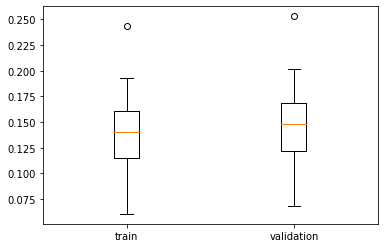

In [81]:
plt.boxplot([loss80,val_loss80])
plt.xticks(np.arange(1,3), ['train','validation'])


This plot showed the variable range of RMSE in the model. It shows we need more than 5 times experimenting to see less error.

Lets experience Adding one layer to the NN:

In [8]:
n_step = 10 
loss10 = []
val_loss10 = []

print((X_train.shape, y_train.shape))
for i  in range(5):

    n_features = X_train.shape[2]
    model = Sequential()
    model.add(LSTM(10, input_shape=(n_step, n_features)))    
    model.add(Dense(12*5, activation='relu'))
    model.add(Dense(n_forcast, activation='relu'))

    model.compile(loss='mean_absolute_error', optimizer='adam')
    history = model.fit(X_train, y_train, epochs = 200, batch_size = 512,
                         validation_data=(X_validation, y_validation))
    
    loss80.append(history.history['loss'][-1])
    val_loss80.append(history.history['val_loss'][-1])

((4032, 10, 3), (4032, 12))
Train on 4032 samples, validate on 2016 samples
Epoch 1/200
4032/4032 [==============================] - 1s 267us/sample - loss: 0.3140 - val_loss: 0.3128
Epoch 2/200
4032/4032 [==============================] - 0s 24us/sample - loss: 0.3000 - val_loss: 0.3033
Epoch 3/200
4032/4032 [==============================] - 0s 24us/sample - loss: 0.2948 - val_loss: 0.3002
Epoch 4/200
4032/4032 [==============================] - 0s 24us/sample - loss: 0.2935 - val_loss: 0.2999
Epoch 5/200
4032/4032 [==============================] - 0s 23us/sample - loss: 0.2935 - val_loss: 0.2999
Epoch 6/200
4032/4032 [==============================] - 0s 25us/sample - loss: 0.2934 - val_loss: 0.2996
Epoch 7/200
4032/4032 [==============================] - 0s 27us/sample - loss: 0.2931 - val_loss: 0.2995
Epoch 8/200
4032/4032 [==============================] - 0s 24us/sample - loss: 0.2930 - val_loss: 0.2995
Epoch 9/200
4032/4032 [==============================] - 0s 25us/sample - l

Epoch 77/200
4032/4032 [==============================] - 0s 28us/sample - loss: 0.1603 - val_loss: 0.1675
Epoch 78/200
4032/4032 [==============================] - 0s 51us/sample - loss: 0.1601 - val_loss: 0.1675
Epoch 79/200
4032/4032 [==============================] - 0s 32us/sample - loss: 0.1601 - val_loss: 0.1675
Epoch 80/200
4032/4032 [==============================] - 0s 28us/sample - loss: 0.1600 - val_loss: 0.1674
Epoch 81/200
4032/4032 [==============================] - 0s 27us/sample - loss: 0.1600 - val_loss: 0.1674
Epoch 82/200
4032/4032 [==============================] - 0s 26us/sample - loss: 0.1601 - val_loss: 0.1674
Epoch 83/200
4032/4032 [==============================] - 0s 26us/sample - loss: 0.1601 - val_loss: 0.1674
Epoch 84/200
4032/4032 [==============================] - 0s 27us/sample - loss: 0.1601 - val_loss: 0.1680
Epoch 85/200
4032/4032 [==============================] - 0s 39us/sample - loss: 0.1602 - val_loss: 0.1677
Epoch 86/200
4032/4032 [=============

4032/4032 [==============================] - 0s 41us/sample - loss: 0.1602 - val_loss: 0.1668
Epoch 154/200
4032/4032 [==============================] - 0s 32us/sample - loss: 0.1603 - val_loss: 0.1684
Epoch 155/200
4032/4032 [==============================] - 0s 38us/sample - loss: 0.1601 - val_loss: 0.1671
Epoch 156/200
4032/4032 [==============================] - 0s 35us/sample - loss: 0.1599 - val_loss: 0.1668
Epoch 157/200
4032/4032 [==============================] - 0s 45us/sample - loss: 0.1596 - val_loss: 0.1668
Epoch 158/200
4032/4032 [==============================] - 0s 32us/sample - loss: 0.1597 - val_loss: 0.1674
Epoch 159/200
4032/4032 [==============================] - 0s 35us/sample - loss: 0.1596 - val_loss: 0.1670
Epoch 160/200
4032/4032 [==============================] - 0s 34us/sample - loss: 0.1597 - val_loss: 0.1672
Epoch 161/200
4032/4032 [==============================] - 0s 34us/sample - loss: 0.1597 - val_loss: 0.1673
Epoch 162/200
4032/4032 [=================

Epoch 29/200
4032/4032 [==============================] - 0s 25us/sample - loss: 0.2575 - val_loss: 0.2619
Epoch 30/200
4032/4032 [==============================] - 0s 26us/sample - loss: 0.2567 - val_loss: 0.2607
Epoch 31/200
4032/4032 [==============================] - 0s 25us/sample - loss: 0.2558 - val_loss: 0.2598
Epoch 32/200
4032/4032 [==============================] - 0s 25us/sample - loss: 0.2548 - val_loss: 0.2592
Epoch 33/200
4032/4032 [==============================] - 0s 25us/sample - loss: 0.2539 - val_loss: 0.2578
Epoch 34/200
4032/4032 [==============================] - 0s 27us/sample - loss: 0.2527 - val_loss: 0.2572
Epoch 35/200
4032/4032 [==============================] - 0s 25us/sample - loss: 0.2516 - val_loss: 0.2561
Epoch 36/200
4032/4032 [==============================] - 0s 27us/sample - loss: 0.2501 - val_loss: 0.2532
Epoch 37/200
4032/4032 [==============================] - 0s 26us/sample - loss: 0.2486 - val_loss: 0.2516
Epoch 38/200
4032/4032 [=============

Epoch 181/200
4032/4032 [==============================] - 0s 25us/sample - loss: 0.1929 - val_loss: 0.2018
Epoch 182/200
4032/4032 [==============================] - 0s 25us/sample - loss: 0.1929 - val_loss: 0.2019
Epoch 183/200
4032/4032 [==============================] - 0s 25us/sample - loss: 0.1930 - val_loss: 0.2018
Epoch 184/200
4032/4032 [==============================] - 0s 26us/sample - loss: 0.1932 - val_loss: 0.2022
Epoch 185/200
4032/4032 [==============================] - 0s 25us/sample - loss: 0.1932 - val_loss: 0.2025
Epoch 186/200
4032/4032 [==============================] - 0s 24us/sample - loss: 0.1930 - val_loss: 0.2019
Epoch 187/200
4032/4032 [==============================] - 0s 25us/sample - loss: 0.1930 - val_loss: 0.2019
Epoch 188/200
4032/4032 [==============================] - 0s 25us/sample - loss: 0.1929 - val_loss: 0.2017
Epoch 189/200
4032/4032 [==============================] - 0s 26us/sample - loss: 0.1930 - val_loss: 0.2021
Epoch 190/200
4032/4032 [===

4032/4032 [==============================] - 0s 26us/sample - loss: 0.1232 - val_loss: 0.1306
Epoch 58/200
4032/4032 [==============================] - 0s 25us/sample - loss: 0.1220 - val_loss: 0.1319
Epoch 59/200
4032/4032 [==============================] - 0s 25us/sample - loss: 0.1200 - val_loss: 0.1280
Epoch 60/200
4032/4032 [==============================] - 0s 28us/sample - loss: 0.1202 - val_loss: 0.1276
Epoch 61/200
4032/4032 [==============================] - 0s 29us/sample - loss: 0.1195 - val_loss: 0.1319
Epoch 62/200
4032/4032 [==============================] - 0s 27us/sample - loss: 0.1210 - val_loss: 0.1272
Epoch 63/200
4032/4032 [==============================] - 0s 26us/sample - loss: 0.1206 - val_loss: 0.1288
Epoch 64/200
4032/4032 [==============================] - 0s 28us/sample - loss: 0.1200 - val_loss: 0.1280
Epoch 65/200
4032/4032 [==============================] - 0s 28us/sample - loss: 0.1192 - val_loss: 0.1287
Epoch 66/200
4032/4032 [==========================

4032/4032 [==============================] - 0s 26us/sample - loss: 0.2527 - val_loss: 0.2533
Epoch 9/200
4032/4032 [==============================] - 0s 25us/sample - loss: 0.2476 - val_loss: 0.2497
Epoch 10/200
4032/4032 [==============================] - 0s 23us/sample - loss: 0.2454 - val_loss: 0.2483
Epoch 11/200
4032/4032 [==============================] - 0s 24us/sample - loss: 0.2446 - val_loss: 0.2479
Epoch 12/200
4032/4032 [==============================] - 0s 25us/sample - loss: 0.2443 - val_loss: 0.2476
Epoch 13/200
4032/4032 [==============================] - 0s 25us/sample - loss: 0.2440 - val_loss: 0.2473
Epoch 14/200
4032/4032 [==============================] - 0s 24us/sample - loss: 0.2436 - val_loss: 0.2471
Epoch 15/200
4032/4032 [==============================] - 0s 25us/sample - loss: 0.2432 - val_loss: 0.2469
Epoch 16/200
4032/4032 [==============================] - 0s 24us/sample - loss: 0.2427 - val_loss: 0.2468
Epoch 17/200
4032/4032 [===========================

4032/4032 [==============================] - 0s 25us/sample - loss: 0.1388 - val_loss: 0.1486
Epoch 161/200
4032/4032 [==============================] - 0s 25us/sample - loss: 0.1380 - val_loss: 0.1436
Epoch 162/200
4032/4032 [==============================] - 0s 26us/sample - loss: 0.1367 - val_loss: 0.1434
Epoch 163/200
4032/4032 [==============================] - 0s 25us/sample - loss: 0.1375 - val_loss: 0.1446
Epoch 164/200
4032/4032 [==============================] - 0s 26us/sample - loss: 0.1374 - val_loss: 0.1451
Epoch 165/200
4032/4032 [==============================] - 0s 27us/sample - loss: 0.1369 - val_loss: 0.1435
Epoch 166/200
4032/4032 [==============================] - 0s 28us/sample - loss: 0.1360 - val_loss: 0.1434
Epoch 167/200
4032/4032 [==============================] - 0s 33us/sample - loss: 0.1360 - val_loss: 0.1434
Epoch 168/200
4032/4032 [==============================] - 0s 42us/sample - loss: 0.1360 - val_loss: 0.1436
Epoch 169/200
4032/4032 [=================

Epoch 36/200
4032/4032 [==============================] - 0s 24us/sample - loss: 0.2542 - val_loss: 0.2626
Epoch 37/200
4032/4032 [==============================] - 0s 24us/sample - loss: 0.2516 - val_loss: 0.2614
Epoch 38/200
4032/4032 [==============================] - 0s 26us/sample - loss: 0.2501 - val_loss: 0.2584
Epoch 39/200
4032/4032 [==============================] - 0s 24us/sample - loss: 0.2490 - val_loss: 0.2580
Epoch 40/200
4032/4032 [==============================] - 0s 24us/sample - loss: 0.2482 - val_loss: 0.2569
Epoch 41/200
4032/4032 [==============================] - 0s 24us/sample - loss: 0.2473 - val_loss: 0.2574
Epoch 42/200
4032/4032 [==============================] - 0s 23us/sample - loss: 0.2469 - val_loss: 0.2563
Epoch 43/200
4032/4032 [==============================] - 0s 24us/sample - loss: 0.2465 - val_loss: 0.2569
Epoch 44/200
4032/4032 [==============================] - 0s 24us/sample - loss: 0.2465 - val_loss: 0.2583
Epoch 45/200
4032/4032 [=============

Epoch 188/200
4032/4032 [==============================] - 0s 25us/sample - loss: 0.2437 - val_loss: 0.2529
Epoch 189/200
4032/4032 [==============================] - 0s 24us/sample - loss: 0.2436 - val_loss: 0.2529
Epoch 190/200
4032/4032 [==============================] - 0s 25us/sample - loss: 0.2436 - val_loss: 0.2528
Epoch 191/200
4032/4032 [==============================] - 0s 25us/sample - loss: 0.2436 - val_loss: 0.2528
Epoch 192/200
4032/4032 [==============================] - 0s 24us/sample - loss: 0.2437 - val_loss: 0.2532
Epoch 193/200
4032/4032 [==============================] - 0s 25us/sample - loss: 0.2438 - val_loss: 0.2528
Epoch 194/200
4032/4032 [==============================] - 0s 24us/sample - loss: 0.2437 - val_loss: 0.2529
Epoch 195/200
4032/4032 [==============================] - 0s 24us/sample - loss: 0.2436 - val_loss: 0.2529
Epoch 196/200
4032/4032 [==============================] - 0s 22us/sample - loss: 0.2436 - val_loss: 0.2529
Epoch 197/200
4032/4032 [===

([<matplotlib.axis.XTick at 0x7f9ed2aa0990>,
 [Text(0, 0, 'train'), Text(0, 0, 'validation')])

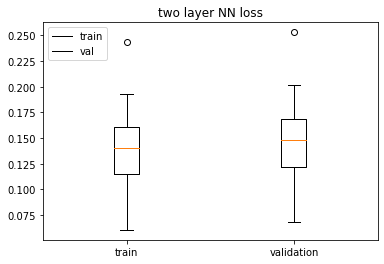

In [82]:
plt.boxplot([loss80,val_loss80])
plt.legend(['train','val'], loc='upper left')
plt.title('two layer NN loss')
plt.xticks(np.arange(1,3), ['train','validation'])


In [11]:
loss80

[0.16127231007530576,
 0.06043325476939716,
 0.11602070537351426,
 0.08278571837951267,
 0.1449811832299308,
 0.1595397180035001,
 0.19291782994118947,
 0.1141709147228135,
 0.13570394094974275,
 0.2437872803873486]

In [12]:
model = Sequential()
model.add(LSTM(10, input_shape=(n_step, n_features)))    
model.add(Dense(12*5, activation='relu'))
model.add(Dense(n_forcast, activation='relu'))

model.compile(loss='mean_absolute_error', optimizer='adam')
history = model.fit(X_train, y_train, epochs = 100, batch_size = 512,
                         validation_data=(X_validation, y_validation))

Train on 4032 samples, validate on 2016 samples
Epoch 1/100
4032/4032 [==============================] - 1s 176us/sample - loss: 0.3140 - val_loss: 0.3023
Epoch 2/100
4032/4032 [==============================] - 0s 28us/sample - loss: 0.2863 - val_loss: 0.2858
Epoch 3/100
4032/4032 [==============================] - 0s 30us/sample - loss: 0.2790 - val_loss: 0.2846
Epoch 4/100
4032/4032 [==============================] - 0s 31us/sample - loss: 0.2791 - val_loss: 0.2848
Epoch 5/100
4032/4032 [==============================] - 0s 28us/sample - loss: 0.2789 - val_loss: 0.2842
Epoch 6/100
4032/4032 [==============================] - 0s 30us/sample - loss: 0.2784 - val_loss: 0.2837
Epoch 7/100
4032/4032 [==============================] - 0s 29us/sample - loss: 0.2781 - val_loss: 0.2837
Epoch 8/100
4032/4032 [==============================] - 0s 27us/sample - loss: 0.2781 - val_loss: 0.2837
Epoch 9/100
4032/4032 [==============================] - 0s 28us/sample - loss: 0.2781 - val_loss: 0.28

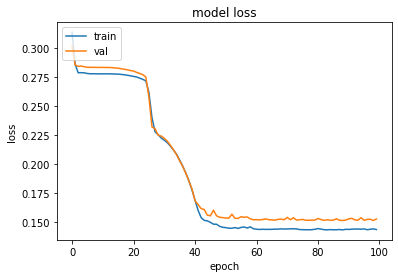

In [13]:

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

Seems we need more that 100 epochs to optimize, 
lets take a look at this simple model predictions and compare it to the real data and the correlation of the predictions and original data:

Train Score for the last prediction(after 60 min): 0.15 RMSE


/Users/saeedsaberi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
  


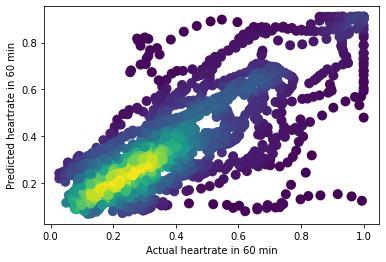

In [14]:
ypredict = model.predict(X_validation, verbose=0)
ypredict = ypredict[:,-1]
ypredict.shape
from scipy.stats import gaussian_kde
y_60min = y_validation[:,-1]
xy = np.vstack([ypredict.T, y_60min])
z = gaussian_kde(xy)(xy)
plt.scatter(y_60min,ypredict, c = z, s=100, edgecolor='')
plt.xlabel('Actual heartrate in 60 min')
plt.ylabel('Predicted heartrate in 60 min')

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_60min, ypredict))
print('Train Score for the last prediction(after 60 min): %.2f RMSE' % (trainScore))

Adding regulaisation to find a more generalizabl mode:

In [15]:
from tensorflow.keras.regularizers import l1,l2,l1_l2

model = Sequential()
model.add(LSTM(10, input_shape=(n_step, n_features),
          kernel_regularizer = l1(0.01), recurrent_regularizer=l1(0.01), bias_regularizer=l1(0.01)) )
model.add(Dense(12*5, activation='relu'
#          kernel_regularizer = l1_l2(l1=0.01))
         ))
model.add(Dense(n_forcast, activation='relu'
#          kernel_regularizer =l1_l2(l1=0.01))
         ))

model.compile(loss='mean_absolute_error', optimizer='adam')
history = model.fit(X_train, y_train, epochs = 200, batch_size = 512,
                         validation_data=(X_validation, y_validation))



Train on 4032 samples, validate on 2016 samples
Epoch 1/200
4032/4032 [==============================] - 2s 414us/sample - loss: 1.1160 - val_loss: 1.0834
Epoch 2/200
4032/4032 [==============================] - 0s 33us/sample - loss: 1.0477 - val_loss: 1.0202
Epoch 3/200
4032/4032 [==============================] - 0s 31us/sample - loss: 0.9898 - val_loss: 0.9673
Epoch 4/200
4032/4032 [==============================] - 0s 30us/sample - loss: 0.9421 - val_loss: 0.9234
Epoch 5/200
4032/4032 [==============================] - 0s 32us/sample - loss: 0.9026 - val_loss: 0.8870
Epoch 6/200
4032/4032 [==============================] - 0s 32us/sample - loss: 0.8681 - val_loss: 0.8541
Epoch 7/200
4032/4032 [==============================] - 0s 38us/sample - loss: 0.8358 - val_loss: 0.8224
Epoch 8/200
4032/4032 [==============================] - 0s 30us/sample - loss: 0.8048 - val_loss: 0.7921
Epoch 9/200
4032/4032 [==============================] - 0s 28us/sample - loss: 0.7749 - val_loss: 0.76

Epoch 77/200
4032/4032 [==============================] - 0s 28us/sample - loss: 0.1683 - val_loss: 0.1765
Epoch 78/200
4032/4032 [==============================] - 0s 29us/sample - loss: 0.1665 - val_loss: 0.1743
Epoch 79/200
4032/4032 [==============================] - 0s 27us/sample - loss: 0.1653 - val_loss: 0.1724
Epoch 80/200
4032/4032 [==============================] - 0s 28us/sample - loss: 0.1642 - val_loss: 0.1749
Epoch 81/200
4032/4032 [==============================] - 0s 30us/sample - loss: 0.1651 - val_loss: 0.1709
Epoch 82/200
4032/4032 [==============================] - 0s 30us/sample - loss: 0.1626 - val_loss: 0.1697
Epoch 83/200
4032/4032 [==============================] - 0s 27us/sample - loss: 0.1620 - val_loss: 0.1689
Epoch 84/200
4032/4032 [==============================] - 0s 29us/sample - loss: 0.1611 - val_loss: 0.1680
Epoch 85/200
4032/4032 [==============================] - 0s 31us/sample - loss: 0.1604 - val_loss: 0.1713
Epoch 86/200
4032/4032 [=============

4032/4032 [==============================] - 0s 22us/sample - loss: 0.1236 - val_loss: 0.1315
Epoch 154/200
4032/4032 [==============================] - 0s 22us/sample - loss: 0.1236 - val_loss: 0.1328
Epoch 155/200
4032/4032 [==============================] - 0s 22us/sample - loss: 0.1246 - val_loss: 0.1318
Epoch 156/200
4032/4032 [==============================] - 0s 22us/sample - loss: 0.1247 - val_loss: 0.1309
Epoch 157/200
4032/4032 [==============================] - 0s 22us/sample - loss: 0.1239 - val_loss: 0.1306
Epoch 158/200
4032/4032 [==============================] - 0s 22us/sample - loss: 0.1232 - val_loss: 0.1307
Epoch 159/200
4032/4032 [==============================] - 0s 20us/sample - loss: 0.1238 - val_loss: 0.1312
Epoch 160/200
4032/4032 [==============================] - 0s 22us/sample - loss: 0.1245 - val_loss: 0.1337
Epoch 161/200
4032/4032 [==============================] - 1s 124us/sample - loss: 0.1246 - val_loss: 0.1326
Epoch 162/200
4032/4032 [================

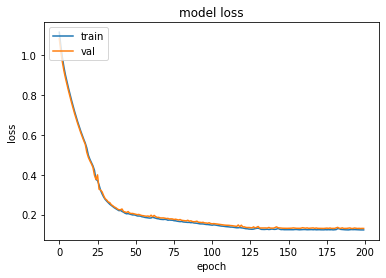

In [16]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

Train Score for the last prediction(after 60 min): 0.14 RMSE


/Users/saeedsaberi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
  


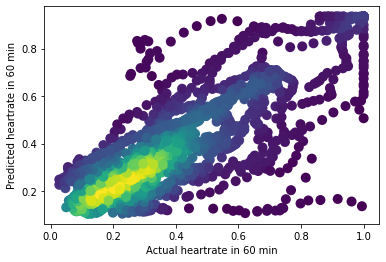

In [17]:
ypredict = model.predict(X_validation, verbose=0)
ypredict = ypredict[:,-1]
ypredict.shape
from scipy.stats import gaussian_kde
y_60min = y_validation[:,-1]
xy = np.vstack([ypredict.T, y_60min])
z = gaussian_kde(xy)(xy)
plt.scatter(y_60min,ypredict, c = z, s=100, edgecolor='')
plt.xlabel('Actual heartrate in 60 min')
plt.ylabel('Predicted heartrate in 60 min')

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_60min, ypredict))
print('Train Score for the last prediction(after 60 min): %.2f RMSE' % (trainScore))

The model with regularization works good.
Lets take a deeper look into the necessary epochs so the model fit reachs its limits:

In [19]:
n_step = 10
X, y = split(dataset[['point_value', 'point_value(mg/dL)']], n_step, n_forcast, ycol)
print(X.shape, y.shape)
X_train, y_train, X_test, y_test = train_test(3*7, 5*7, X, y)
print((X_train.shape, y_train.shape))
X_train, y_train, X_validation , y_validation  = train_test(2*7, 1*7, X_train, y_train)
print((X_train.shape, y_train.shape))
n_features = X.shape[2]




(14680, 10, 2) (14680, 12)
((6048, 10, 2), (6048, 12))
((4032, 10, 2), (4032, 12))


Train on 4032 samples, validate on 2016 samples
Epoch 1/300
4032/4032 [==============================] - 1s 203us/sample - loss: 1.0126 - val_loss: 0.9777
Epoch 2/300
4032/4032 [==============================] - 0s 22us/sample - loss: 0.9476 - val_loss: 0.9223
Epoch 3/300
4032/4032 [==============================] - 0s 22us/sample - loss: 0.9010 - val_loss: 0.8824
Epoch 4/300
4032/4032 [==============================] - 0s 25us/sample - loss: 0.8652 - val_loss: 0.8490
Epoch 5/300
4032/4032 [==============================] - 0s 28us/sample - loss: 0.8320 - val_loss: 0.8154
Epoch 6/300
4032/4032 [==============================] - 0s 23us/sample - loss: 0.7987 - val_loss: 0.7831
Epoch 7/300
4032/4032 [==============================] - 0s 23us/sample - loss: 0.7673 - val_loss: 0.7526
Epoch 8/300
4032/4032 [==============================] - 0s 23us/sample - loss: 0.7370 - val_loss: 0.7231
Epoch 9/300
4032/4032 [==============================] - 0s 30us/sample - loss: 0.7081 - val_loss: 0.69

4032/4032 [==============================] - 0s 22us/sample - loss: 0.1454 - val_loss: 0.1528
Epoch 154/300
4032/4032 [==============================] - 0s 23us/sample - loss: 0.1456 - val_loss: 0.1538
Epoch 155/300
4032/4032 [==============================] - 0s 24us/sample - loss: 0.1458 - val_loss: 0.1547
Epoch 156/300
4032/4032 [==============================] - 0s 22us/sample - loss: 0.1460 - val_loss: 0.1534
Epoch 157/300
4032/4032 [==============================] - 0s 22us/sample - loss: 0.1454 - val_loss: 0.1527
Epoch 158/300
4032/4032 [==============================] - 0s 22us/sample - loss: 0.1456 - val_loss: 0.1530
Epoch 159/300
4032/4032 [==============================] - 0s 21us/sample - loss: 0.1459 - val_loss: 0.1529
Epoch 160/300
4032/4032 [==============================] - 0s 22us/sample - loss: 0.1452 - val_loss: 0.1558
Epoch 161/300
4032/4032 [==============================] - 0s 21us/sample - loss: 0.1463 - val_loss: 0.1589
Epoch 162/300
4032/4032 [=================

Epoch 229/300
4032/4032 [==============================] - 0s 23us/sample - loss: 0.1467 - val_loss: 0.1525
Epoch 230/300
4032/4032 [==============================] - 0s 24us/sample - loss: 0.1473 - val_loss: 0.1532
Epoch 231/300
4032/4032 [==============================] - 0s 23us/sample - loss: 0.1456 - val_loss: 0.1523
Epoch 232/300
4032/4032 [==============================] - 0s 25us/sample - loss: 0.1448 - val_loss: 0.1526
Epoch 233/300
4032/4032 [==============================] - 0s 24us/sample - loss: 0.1462 - val_loss: 0.1533
Epoch 234/300
4032/4032 [==============================] - 0s 25us/sample - loss: 0.1456 - val_loss: 0.1530
Epoch 235/300
4032/4032 [==============================] - 0s 23us/sample - loss: 0.1456 - val_loss: 0.1523
Epoch 236/300
4032/4032 [==============================] - 0s 24us/sample - loss: 0.1454 - val_loss: 0.1573
Epoch 237/300
4032/4032 [==============================] - 0s 25us/sample - loss: 0.1463 - val_loss: 0.1527
Epoch 238/300
4032/4032 [===

/Users/saeedsaberi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.


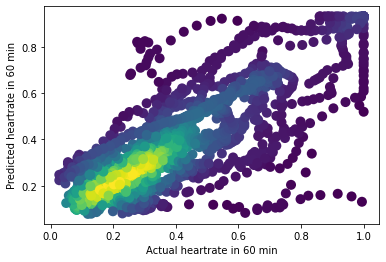

In [20]:
model = Sequential()
model.add(LSTM(10, input_shape=(n_step, n_features),
          kernel_regularizer = l1(0.01), recurrent_regularizer=l1(0.01), bias_regularizer=l1(0.01)) )
model.add(Dense(12*5, activation='relu'
#          kernel_regularizer = l1_l2(l1=0.01))
         ))
model.add(Dense(n_forcast, activation='relu'
#          kernel_regularizer =l1_l2(l1=0.01))
         ))

model.compile(loss='mean_absolute_error', optimizer='adam')
history = model.fit(X_train, y_train, epochs = 300, batch_size = 512,
                         validation_data=(X_validation, y_validation))

ypredict = model.predict(X_validation, verbose=0)
ypredict = ypredict[:,-1]
ypredict.shape
from scipy.stats import gaussian_kde
y_60min = y_validation[:,-1]
xy = np.vstack([ypredict.T, y_60min])
z = gaussian_kde(xy)(xy)
plt.scatter(y_60min,ypredict, c = z, s=100, edgecolor='')
plt.xlabel('Actual heartrate in 60 min')
plt.ylabel('Predicted heartrate in 60 min')

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_60min, ypredict))
print('Train Score for the last prediction(after 60 min): %.2f RMSE' % (trainScore))

Train on 4032 samples, validate on 2016 samples
Epoch 1/300
4032/4032 [==============================] - 1s 189us/sample - loss: 1.0962 - val_loss: 1.0839
Epoch 2/300
4032/4032 [==============================] - 0s 22us/sample - loss: 1.0554 - val_loss: 1.0439
Epoch 3/300
4032/4032 [==============================] - 0s 22us/sample - loss: 1.0153 - val_loss: 1.0045
Epoch 4/300
4032/4032 [==============================] - 0s 23us/sample - loss: 0.9757 - val_loss: 0.9649
Epoch 5/300
4032/4032 [==============================] - 0s 22us/sample - loss: 0.9350 - val_loss: 0.9222
Epoch 6/300
4032/4032 [==============================] - 0s 27us/sample - loss: 0.8895 - val_loss: 0.8727
Epoch 7/300
4032/4032 [==============================] - 0s 37us/sample - loss: 0.8437 - val_loss: 0.8306
Epoch 8/300
4032/4032 [==============================] - 0s 31us/sample - loss: 0.8097 - val_loss: 0.8007
Epoch 9/300
4032/4032 [==============================] - 0s 22us/sample - loss: 0.7795 - val_loss: 0.76

Epoch 77/300
4032/4032 [==============================] - 0s 21us/sample - loss: 0.1416 - val_loss: 0.1442
Epoch 78/300
4032/4032 [==============================] - 0s 22us/sample - loss: 0.1375 - val_loss: 0.1452
Epoch 79/300
4032/4032 [==============================] - 0s 21us/sample - loss: 0.1372 - val_loss: 0.1469
Epoch 80/300
4032/4032 [==============================] - 0s 22us/sample - loss: 0.1356 - val_loss: 0.1394
Epoch 81/300
4032/4032 [==============================] - 0s 21us/sample - loss: 0.1325 - val_loss: 0.1374
Epoch 82/300
4032/4032 [==============================] - 0s 21us/sample - loss: 0.1316 - val_loss: 0.1365
Epoch 83/300
4032/4032 [==============================] - 0s 21us/sample - loss: 0.1308 - val_loss: 0.1347
Epoch 84/300
4032/4032 [==============================] - 0s 26us/sample - loss: 0.1288 - val_loss: 0.1331
Epoch 85/300
4032/4032 [==============================] - 0s 26us/sample - loss: 0.1262 - val_loss: 0.1355
Epoch 86/300
4032/4032 [=============

4032/4032 [==============================] - 0s 22us/sample - loss: 0.0803 - val_loss: 0.0863
Epoch 154/300
4032/4032 [==============================] - 0s 20us/sample - loss: 0.0843 - val_loss: 0.0916
Epoch 155/300
4032/4032 [==============================] - 0s 20us/sample - loss: 0.0835 - val_loss: 0.0935
Epoch 156/300
4032/4032 [==============================] - 0s 20us/sample - loss: 0.0795 - val_loss: 0.0852
Epoch 157/300
4032/4032 [==============================] - 0s 19us/sample - loss: 0.0772 - val_loss: 0.0840
Epoch 158/300
4032/4032 [==============================] - 0s 22us/sample - loss: 0.0772 - val_loss: 0.0839
Epoch 159/300
4032/4032 [==============================] - 0s 21us/sample - loss: 0.0768 - val_loss: 0.0831
Epoch 160/300
4032/4032 [==============================] - 0s 20us/sample - loss: 0.0775 - val_loss: 0.0829
Epoch 161/300
4032/4032 [==============================] - 0s 21us/sample - loss: 0.0799 - val_loss: 0.0924
Epoch 162/300
4032/4032 [=================

Epoch 229/300
4032/4032 [==============================] - 0s 22us/sample - loss: 0.0734 - val_loss: 0.0797
Epoch 230/300
4032/4032 [==============================] - 0s 26us/sample - loss: 0.0734 - val_loss: 0.0799
Epoch 231/300
4032/4032 [==============================] - 0s 23us/sample - loss: 0.0745 - val_loss: 0.0850
Epoch 232/300
4032/4032 [==============================] - 0s 25us/sample - loss: 0.0749 - val_loss: 0.0797
Epoch 233/300
4032/4032 [==============================] - 0s 23us/sample - loss: 0.0749 - val_loss: 0.0815
Epoch 234/300
4032/4032 [==============================] - 0s 22us/sample - loss: 0.0748 - val_loss: 0.0808
Epoch 235/300
4032/4032 [==============================] - 0s 22us/sample - loss: 0.0741 - val_loss: 0.0900
Epoch 236/300
4032/4032 [==============================] - 0s 23us/sample - loss: 0.0767 - val_loss: 0.0878
Epoch 237/300
4032/4032 [==============================] - 0s 23us/sample - loss: 0.0756 - val_loss: 0.0819
Epoch 238/300
4032/4032 [===

/Users/saeedsaberi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.


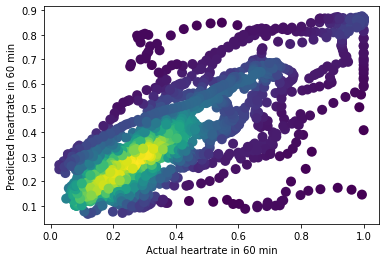

In [21]:
model = Sequential()
model.add(LSTM(10, input_shape=(n_step, n_features),
          kernel_regularizer = l1(0.01), recurrent_regularizer=l1(0.01), bias_regularizer=l1(0.01)) )

model.add(Dense(n_forcast, activation='relu'
#          kernel_regularizer =l1_l2(l1=0.01))
         ))

model.compile(loss='mean_absolute_error', optimizer='adam')
history = model.fit(X_train, y_train, epochs = 300, batch_size = 512,
                         validation_data=(X_validation, y_validation))

ypredict = model.predict(X_validation, verbose=0)
ypredict = ypredict[:,-1]
ypredict.shape
from scipy.stats import gaussian_kde
y_60min = y_validation[:,-1]
xy = np.vstack([ypredict.T, y_60min])
z = gaussian_kde(xy)(xy)
plt.scatter(y_60min,ypredict, c = z, s=100, edgecolor='')
plt.xlabel('Actual heartrate in 60 min')
plt.ylabel('Predicted heartrate in 60 min')

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_60min, ypredict))
print('Train Score for the last prediction(after 60 min): %.2f RMSE' % (trainScore))

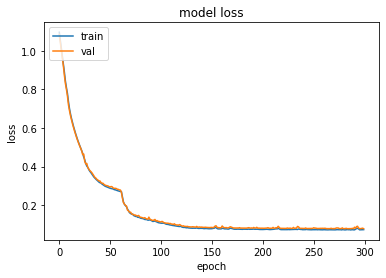

In [22]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

Seems 300 epochs should be enough...

# Optimizing for n_stap :
Modifying number of previous data points to use for to predict the blood glucose

Using the following features in the mdoel: 'point_value', 'point_value(mg/dL)'

(14685, 5, 2) (14685, 12)
((6048, 5, 2), (6048, 12))
((4032, 5, 2), (4032, 12))


/Users/saeedsaberi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.


Train Score for the last prediction(after 60 min): 0.15 RMSE
(14680, 10, 2) (14680, 12)
((6048, 10, 2), (6048, 12))
((4032, 10, 2), (4032, 12))


/Users/saeedsaberi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.


Train Score for the last prediction(after 60 min): 0.14 RMSE
(14675, 15, 2) (14675, 12)
((6048, 15, 2), (6048, 12))
((4032, 15, 2), (4032, 12))


/Users/saeedsaberi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.


Train Score for the last prediction(after 60 min): 0.14 RMSE
(14670, 20, 2) (14670, 12)
((6048, 20, 2), (6048, 12))
((4032, 20, 2), (4032, 12))


/Users/saeedsaberi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.


Train Score for the last prediction(after 60 min): 0.15 RMSE
(14665, 25, 2) (14665, 12)
((6048, 25, 2), (6048, 12))
((4032, 25, 2), (4032, 12))


/Users/saeedsaberi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.


Train Score for the last prediction(after 60 min): 0.45 RMSE
(14660, 30, 2) (14660, 12)
((6048, 30, 2), (6048, 12))
((4032, 30, 2), (4032, 12))


/Users/saeedsaberi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.


Train Score for the last prediction(after 60 min): 0.14 RMSE
(14655, 35, 2) (14655, 12)
((6048, 35, 2), (6048, 12))
((4032, 35, 2), (4032, 12))


/Users/saeedsaberi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.


Train Score for the last prediction(after 60 min): 0.14 RMSE
(14650, 40, 2) (14650, 12)
((6048, 40, 2), (6048, 12))
((4032, 40, 2), (4032, 12))


/Users/saeedsaberi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.


Train Score for the last prediction(after 60 min): 0.14 RMSE
(14645, 45, 2) (14645, 12)
((6048, 45, 2), (6048, 12))
((4032, 45, 2), (4032, 12))


/Users/saeedsaberi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.


Train Score for the last prediction(after 60 min): 0.14 RMSE
(14640, 50, 2) (14640, 12)
((6048, 50, 2), (6048, 12))
((4032, 50, 2), (4032, 12))


/Users/saeedsaberi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.


Train Score for the last prediction(after 60 min): 0.14 RMSE
(14635, 55, 2) (14635, 12)
((6048, 55, 2), (6048, 12))
((4032, 55, 2), (4032, 12))


/Users/saeedsaberi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.


Train Score for the last prediction(after 60 min): 0.14 RMSE
(14630, 60, 2) (14630, 12)
((6048, 60, 2), (6048, 12))
((4032, 60, 2), (4032, 12))


/Users/saeedsaberi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.


Train Score for the last prediction(after 60 min): 0.14 RMSE
(14625, 65, 2) (14625, 12)
((6048, 65, 2), (6048, 12))
((4032, 65, 2), (4032, 12))


/Users/saeedsaberi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.


Train Score for the last prediction(after 60 min): 0.14 RMSE
(14620, 70, 2) (14620, 12)
((6048, 70, 2), (6048, 12))
((4032, 70, 2), (4032, 12))


/Users/saeedsaberi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.


Train Score for the last prediction(after 60 min): 0.44 RMSE
(14615, 75, 2) (14615, 12)
((6048, 75, 2), (6048, 12))
((4032, 75, 2), (4032, 12))


/Users/saeedsaberi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.


Train Score for the last prediction(after 60 min): 0.14 RMSE
(14610, 80, 2) (14610, 12)
((6048, 80, 2), (6048, 12))
((4032, 80, 2), (4032, 12))


/Users/saeedsaberi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.


Train Score for the last prediction(after 60 min): 0.14 RMSE
(14605, 85, 2) (14605, 12)
((6048, 85, 2), (6048, 12))
((4032, 85, 2), (4032, 12))


/Users/saeedsaberi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.


Train Score for the last prediction(after 60 min): 0.14 RMSE
(14600, 90, 2) (14600, 12)
((6048, 90, 2), (6048, 12))
((4032, 90, 2), (4032, 12))


/Users/saeedsaberi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.


Train Score for the last prediction(after 60 min): 0.14 RMSE
(14595, 95, 2) (14595, 12)
((6048, 95, 2), (6048, 12))
((4032, 95, 2), (4032, 12))


/Users/saeedsaberi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.


Train Score for the last prediction(after 60 min): 0.14 RMSE
(14590, 100, 2) (14590, 12)
((6048, 100, 2), (6048, 12))
((4032, 100, 2), (4032, 12))
Train Score for the last prediction(after 60 min): 0.14 RMSE
20


/Users/saeedsaberi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.


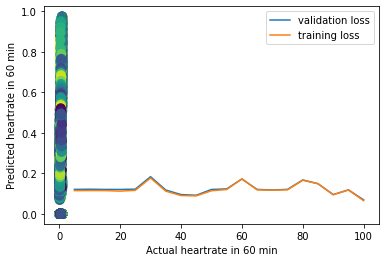

In [23]:
val_loss = []
loss = []

for n_step in range(5,101,5): 
    X, y = split(dataset[['point_value', 'point_value(mg/dL)']], n_step, n_forcast,ycol)
    print(X.shape, y.shape)
    X_train, y_train, X_test, y_test = train_test(3*7, 5*7, X, y)
    print((X_train.shape, y_train.shape))
    X_train, y_train, X_validation , y_validation  = train_test(2*7, 1*7, X_train, y_train)
    print((X_train.shape, y_train.shape))
    n_features = X.shape[2]
    model = Sequential()
    model.add(LSTM(10, input_shape=(n_step, n_features),
              kernel_regularizer = l1(0.01), recurrent_regularizer=l1(0.01), bias_regularizer=l1(0.01)) )
    model.add(Dense(12*5, activation='relu'
    #          kernel_regularizer = l1_l2(l1=0.01))
             ))
    model.add(Dense(n_forcast, activation='relu'
    #          kernel_regularizer =l1_l2(l1=0.01))
             ))

    model.compile(loss='mean_absolute_error', optimizer='adam')
    history = model.fit(X_train, y_train, epochs = 300, batch_size = 512, verbose = 0,
                             validation_data=(X_validation, y_validation))
    h = history.history['val_loss']
    val_loss.append(h[-1])
    h = history.history['loss']
    loss.append(h[-1])
    
    ypredict = model.predict(X_validation, verbose=0)
    ypredict = ypredict[:,-1]
    ypredict.shape
    from scipy.stats import gaussian_kde
    y_60min = y_validation[:,-1]
    xy = np.vstack([ypredict.T, y_60min])
#     z = gaussian_kde(xy)(xy)
    plt.scatter(y_60min,ypredict, c = z, s=100, edgecolor='')
    plt.xlabel('Actual heartrate in 60 min')
    plt.ylabel('Predicted heartrate in 60 min')

    # calculate root mean squared error
    trainScore = math.sqrt(mean_squared_error(y_60min, ypredict))
    print('Train Score for the last prediction(after 60 min): %.2f RMSE' % (trainScore))



20


/Users/saeedsaberi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Unrecognized location 'top left'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.
  after removing the cwd from sys.path.


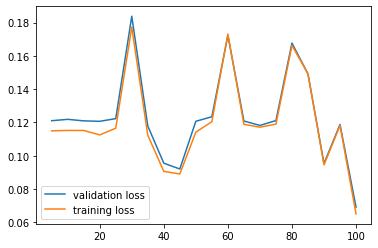

In [24]:
print(len(loss))
plt.plot(range(5,101,5), val_loss)
plt.plot(range(5,101,5), loss)
plt.legend(['validation loss','training loss'], loc='top left')


In [38]:
n_step = 100
lstmmemory = 10
X, y = split(dataset[['point_value', 'point_value(mg/dL)']], 
                           n_step, n_forcast, ycol)
print(X.shape, y.shape)
X_train, y_train, X_test, y_test = train_test(3*7, 5*7, X, y)
print((X_train.shape, y_train.shape))
X_train, y_train, X_validation , y_validation  = train_test(2*7, 1*7, X_train, y_train)
print((X_train.shape, y_train.shape))
print((X_validation.shape, y_validation.shape))
n_features = X.shape[2]
model_100 = Sequential()
model_100.add(LSTM(lstmmemory, input_shape=(n_step, n_features),
              kernel_regularizer = l1(0.01), recurrent_regularizer=l1(0.01), bias_regularizer=l1(0.01)) )
model_100.add(Dense(12*5, activation='relu'
    #          kernel_regularizer = l1_l2(l1=0.01))
             ))
model_100.add(Dense(n_forcast, activation='relu'
    #          kernel_regularizer =l1_l2(l1=0.01))
             ))
model_100.compile(loss='mean_absolute_error', optimizer='adam')
history = model_100.fit(X_train, y_train, epochs = 300, batch_size = 1024, 
                             validation_data=(X_validation, y_validation))


(14590, 100, 2) (14590, 12)
((6048, 100, 2), (6048, 12))
((4032, 100, 2), (4032, 12))
((2016, 100, 2), (2016, 12))
Train on 4032 samples, validate on 2016 samples
Epoch 1/300
4032/4032 [==============================] - 2s 393us/sample - loss: 1.0613 - val_loss: 1.0274
Epoch 2/300
4032/4032 [==============================] - 1s 303us/sample - loss: 1.0189 - val_loss: 0.9867
Epoch 3/300
4032/4032 [==============================] - 1s 205us/sample - loss: 0.9801 - val_loss: 0.9512
Epoch 4/300
4032/4032 [==============================] - 1s 282us/sample - loss: 0.9480 - val_loss: 0.9250
Epoch 5/300
4032/4032 [==============================] - 1s 274us/sample - loss: 0.9245 - val_loss: 0.9059
Epoch 6/300
4032/4032 [==============================] - 1s 204us/sample - loss: 0.9060 - val_loss: 0.8895
Epoch 7/300
4032/4032 [==============================] - 1s 189us/sample - loss: 0.8893 - val_loss: 0.8726
Epoch 8/300
4032/4032 [==============================] - 1s 208us/sample - loss: 0.8723 

4032/4032 [==============================] - 1s 218us/sample - loss: 0.1916 - val_loss: 0.1914
Epoch 151/300
4032/4032 [==============================] - 1s 263us/sample - loss: 0.1915 - val_loss: 0.1918
Epoch 152/300
4032/4032 [==============================] - 1s 209us/sample - loss: 0.1916 - val_loss: 0.1906
Epoch 153/300
4032/4032 [==============================] - 1s 197us/sample - loss: 0.1910 - val_loss: 0.1915
Epoch 154/300
4032/4032 [==============================] - 1s 167us/sample - loss: 0.1903 - val_loss: 0.1911
Epoch 155/300
4032/4032 [==============================] - 1s 182us/sample - loss: 0.1898 - val_loss: 0.1903
Epoch 156/300
4032/4032 [==============================] - 1s 177us/sample - loss: 0.1893 - val_loss: 0.1889
Epoch 157/300
4032/4032 [==============================] - 1s 175us/sample - loss: 0.1894 - val_loss: 0.1916
Epoch 158/300
4032/4032 [==============================] - 1s 195us/sample - loss: 0.1906 - val_loss: 0.1915
Epoch 159/300
4032/4032 [========

4032/4032 [==============================] - 1s 336us/sample - loss: 0.1496 - val_loss: 0.1507


/Users/saeedsaberi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
  import sys


Train Score for the last prediction(after 60 min): 0.1410 RMSE


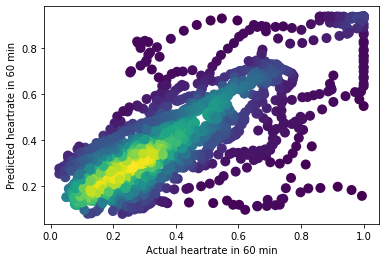

In [39]:

ypredict = model_30.predict(X_validation, verbose=0)  
ypredict = ypredict[:,-1]
ypredict.shape
y_60min = y_validation[:,-1]
xy = np.vstack([ypredict.T, y_60min])
z = gaussian_kde(xy)(xy)
plt.scatter(y_60min,ypredict, c=z, s=100, edgecolor='')
plt.xlabel('Actual heartrate in 60 min')
plt.ylabel('Predicted heartrate in 60 min')
trainScore = math.sqrt(mean_squared_error(y_60min, ypredict))
print('Train Score for the last prediction(after 60 min): %.4f RMSE' % (trainScore))

Optimizing for LSTM layer:

In [34]:
n_step = 100
val_loss = []
loss = []

for lstmmemory in range(10,31,5): 
    X, y = split(dataset[['point_value', 'point_value(mg/dL)']], n_step, n_forcast,ycol)
    print(X.shape, y.shape)
    X_train, y_train, X_test, y_test = train_test(3*7, 5*7, X, y)
    print((X_train.shape, y_train.shape))
    X_train, y_train, X_validation , y_validation  = train_test(2*7, 1*7, X_train, y_train)
    print((X_train.shape, y_train.shape))
    n_features = X.shape[2]
    model = Sequential()
    model.add(LSTM(lstmmemory, input_shape=(n_step, n_features),
              kernel_regularizer = l1(0.01), recurrent_regularizer=l1(0.01), bias_regularizer=l1(0.01)) )
    model.add(Dense(12*5, activation='relu'
    #          kernel_regularizer = l1_l2(l1=0.01))
             ))
    model.add(Dense(n_forcast, activation='relu'
    #          kernel_regularizer =l1_l2(l1=0.01))
             ))

    model.compile(loss='mean_absolute_error', optimizer='adam')
    history = model.fit(X_train, y_train, epochs = 200, batch_size = 1024, verbose = 0,
                          validation_data=(X_validation, y_validation))
    h = history.history['val_loss']
    val_loss.append(h[-1])
    h = history.history['loss']
    loss.append(h[-1])
    
    ypredict = model.predict(X_validation, verbose=0)
    ypredict = ypredict[:,-1]
    ypredict.shape
    from scipy.stats import gaussian_kde
    y_60min = y_validation[:,-1]
#     xy = np.vstack([ypredict.T, y_60min])
#     z = gaussian_kde(xy)(xy)
#     plt.scatter(y_60min,ypredict, c = z, s=100, edgecolor='')
#     plt.xlabel('Actual heartrate in 60 min')
#     plt.ylabel('Predicted heartrate in 60 min')

    # calculate root mean squared error
    trainScore = math.sqrt(mean_squared_error(y_60min, ypredict))
    print('Train Score for the last prediction(after 60 min): %.4f RMSE' % (trainScore))

(14660, 30, 2) (14660, 12)
((6048, 30, 2), (6048, 12))
((4032, 30, 2), (4032, 12))
Train Score for the last prediction(after 60 min): 0.4459 RMSE
(14660, 30, 2) (14660, 12)
((6048, 30, 2), (6048, 12))
((4032, 30, 2), (4032, 12))
Train Score for the last prediction(after 60 min): 0.1472 RMSE
(14660, 30, 2) (14660, 12)
((6048, 30, 2), (6048, 12))
((4032, 30, 2), (4032, 12))
Train Score for the last prediction(after 60 min): 0.1467 RMSE
(14660, 30, 2) (14660, 12)
((6048, 30, 2), (6048, 12))
((4032, 30, 2), (4032, 12))
Train Score for the last prediction(after 60 min): 0.1498 RMSE
(14660, 30, 2) (14660, 12)
((6048, 30, 2), (6048, 12))
((4032, 30, 2), (4032, 12))
Train Score for the last prediction(after 60 min): 0.1458 RMSE
(14660, 30, 2) (14660, 12)
((6048, 30, 2), (6048, 12))
((4032, 30, 2), (4032, 12))
Train Score for the last prediction(after 60 min): 0.1453 RMSE
(14660, 30, 2) (14660, 12)
((6048, 30, 2), (6048, 12))
((4032, 30, 2), (4032, 12))
Train Score for the last prediction(after

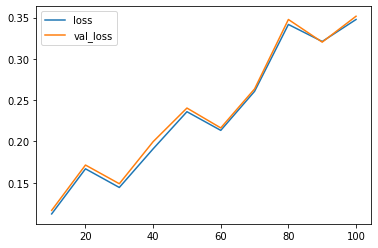

In [35]:
plt.plot(range(10,101,10), loss)
plt.plot(range(10,101,10), val_loss)
plt.legend(['loss', 'val_loss'])


Therefore, the chosen model will have a 50 LSTM memory! It is important to mention that these steps should be iterated for few times to have a better understanding of optimal values for the losses, but this was beyond my laptop computational power.

# Experimenting with adding point_value(kilometers) to the features: 

In [40]:
val_loss = []
loss = []
ycol = 'point_value(mg/dL)'




for n_step in range(10,101,20): 
    X, y = split(dataset[['point_value', 'point_value(mg/dL)','point_value(kilometers)']], 
                               n_step, n_forcast, ycol)
    print(X.shape, y.shape)
    X_train, y_train, X_test, y_test = train_test(3*7, 5*7, X, y)
    print((X_train.shape, y_train.shape))
    X_train, y_train, X_validation , y_validation  = train_test(2*7, 1*7, X_train, y_train)
    print((X_train.shape, y_train.shape))
    print((X_validation.shape, y_validation.shape))
    n_features = X.shape[2]
    model = Sequential()
    model.add(LSTM(10, input_shape=(n_step, n_features),
              kernel_regularizer = l1(0.01), recurrent_regularizer=l1(0.01), bias_regularizer=l1(0.01)) )
    model.add(Dense(12*5, activation='relu'
    #          kernel_regularizer = l1_l2(l1=0.01))
             ))
    model.add(Dense(n_forcast, activation='relu'
    #          kernel_regularizer =l1_l2(l1=0.01))
             ))

    model.compile(loss='mean_absolute_error', optimizer='adam')
    history = model.fit(X_train, y_train, epochs = 100, batch_size = 1024, verbose = 0,
                             validation_data=(X_validation, y_validation))
    h = history.history['val_loss']
    val_loss.append(h[-1])
    h = history.history['loss']
    loss.append(h[-1])
    print('loss is:')
    print((val_loss[-1],loss[-1]))
    

    # calculate root mean squared error
    trainScore = math.sqrt(mean_squared_error(y_60min, ypredict))
    print('Train Score for the last prediction(after 60 min): %.4f RMSE' % (trainScore))


(14680, 10, 3) (14680, 12)
((6048, 10, 3), (6048, 12))
((4032, 10, 3), (4032, 12))
((2016, 10, 3), (2016, 12))
loss is:
(0.23077662312795247, 0.2230065062878624)
Train Score for the last prediction(after 60 min): 0.1410 RMSE
(14660, 30, 3) (14660, 12)
((6048, 30, 3), (6048, 12))
((4032, 30, 3), (4032, 12))
((2016, 30, 3), (2016, 12))
loss is:
(0.16991715346063888, 0.16455062183122787)
Train Score for the last prediction(after 60 min): 0.1410 RMSE
(14640, 50, 3) (14640, 12)
((6048, 50, 3), (6048, 12))
((4032, 50, 3), (4032, 12))
((2016, 50, 3), (2016, 12))
loss is:
(0.18146660119768174, 0.17712495393223232)
Train Score for the last prediction(after 60 min): 0.1410 RMSE
(14620, 70, 3) (14620, 12)
((6048, 70, 3), (6048, 12))
((4032, 70, 3), (4032, 12))
((2016, 70, 3), (2016, 12))
loss is:
(0.20461368466180468, 0.19630950925842164)
Train Score for the last prediction(after 60 min): 0.1410 RMSE
(14600, 90, 3) (14600, 12)
((6048, 90, 3), (6048, 12))
((4032, 90, 3), (4032, 12))
((2016, 90, 3)

5


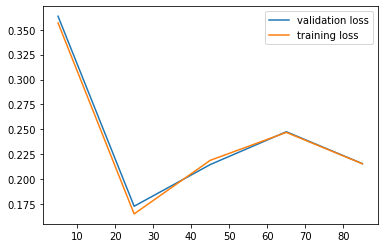

In [37]:
print(len(loss))
plt.plot(range(5,101,20), val_loss)
plt.plot(range(5,101,20), loss)
plt.legend(['validation loss','training loss'])

Does not seem adding distance would help the model

# Conclusion and the summary of performance:

Adding  the distance values dd not improve the prdiction so we stick with the prvious model and calculate the accuracy metric as following:

In [70]:
def MARD(ypredict, y_validation ):
    from sklearn.metrics import mean_absolute_error
    
    devided = np.divide(ypredict - y_validation, ypredict)
    devided = abs(devided[devided != np.inf])
    devided = devided[devided != np.inf]
    MARD = np.nanmean(devided)
    return MARD




In [45]:
n_step = 100
lstmmemory = 10
X, y = split(dataset[['point_value', 'point_value(mg/dL)']], 
                           n_step, n_forcast, ycol)
print(X.shape, y.shape)
X_train, y_train, X_test, y_test = train_test(3*7, 5*7, X, y)
print((X_train.shape, y_train.shape))
X_train, y_train, X_validation , y_validation  = train_test(2*7, 1*7, X_train, y_train)
print((X_train.shape, y_train.shape))
print((X_validation.shape, y_validation.shape))
n_features = X.shape[2]
model_100 = Sequential()
model_100.add(LSTM(lstmmemory, input_shape=(n_step, n_features),
              kernel_regularizer = l1(0.01), recurrent_regularizer=l1(0.01), bias_regularizer=l1(0.01)) )
model_100.add(Dense(12*5, activation='relu'
    #          kernel_regularizer = l1_l2(l1=0.01))
             ))
model_100.add(Dense(n_forcast, activation='relu'
    #          kernel_regularizer =l1_l2(l1=0.01))
             ))
model_100.compile(loss='mean_absolute_error', optimizer='adam')
history = model_100.fit(X_train, y_train, epochs = 300, batch_size = 1024, 
                             validation_data=(X_validation, y_validation))



(14590, 100, 2) (14590, 12)
((6048, 100, 2), (6048, 12))
((4032, 100, 2), (4032, 12))
((2016, 100, 2), (2016, 12))
Train on 4032 samples, validate on 2016 samples
Epoch 1/300
4032/4032 [==============================] - 2s 403us/sample - loss: 1.0835 - val_loss: 1.0571
Epoch 2/300
4032/4032 [==============================] - 1s 166us/sample - loss: 1.0571 - val_loss: 1.0389
Epoch 3/300
4032/4032 [==============================] - 1s 188us/sample - loss: 1.0274 - val_loss: 0.9994
Epoch 4/300
4032/4032 [==============================] - 1s 240us/sample - loss: 1.0009 - val_loss: 0.9794
Epoch 5/300
4032/4032 [==============================] - 1s 235us/sample - loss: 0.9763 - val_loss: 0.9597
Epoch 6/300
4032/4032 [==============================] - 1s 199us/sample - loss: 0.9563 - val_loss: 0.9289
Epoch 7/300
4032/4032 [==============================] - 1s 208us/sample - loss: 0.9287 - val_loss: 0.9176
Epoch 8/300
4032/4032 [==============================] - 1s 200us/sample - loss: 0.9142 

4032/4032 [==============================] - 1s 199us/sample - loss: 0.1905 - val_loss: 0.1896
Epoch 151/300
4032/4032 [==============================] - 1s 194us/sample - loss: 0.1899 - val_loss: 0.1907
Epoch 152/300
4032/4032 [==============================] - 1s 166us/sample - loss: 0.1894 - val_loss: 0.1896
Epoch 153/300
4032/4032 [==============================] - 1s 162us/sample - loss: 0.1890 - val_loss: 0.1891
Epoch 154/300
4032/4032 [==============================] - 1s 177us/sample - loss: 0.1881 - val_loss: 0.1875
Epoch 155/300
4032/4032 [==============================] - 1s 168us/sample - loss: 0.1872 - val_loss: 0.1870
Epoch 156/300
4032/4032 [==============================] - 1s 168us/sample - loss: 0.1869 - val_loss: 0.1870
Epoch 157/300
4032/4032 [==============================] - 1s 187us/sample - loss: 0.1868 - val_loss: 0.1872
Epoch 158/300
4032/4032 [==============================] - 1s 190us/sample - loss: 0.1865 - val_loss: 0.1861
Epoch 159/300
4032/4032 [========

4032/4032 [==============================] - 1s 175us/sample - loss: 0.1260 - val_loss: 0.1252


/Users/saeedsaberi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
  import sys


Train Score for the last prediction(after 60 min): 0.1415 RMSE


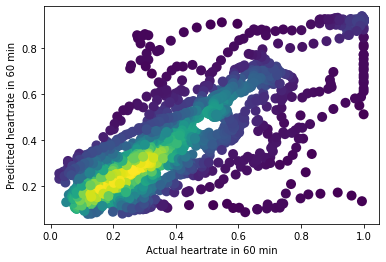

In [46]:
ypredict = model_100.predict(X_validation, verbose=0)  
ypredict = ypredict[:,-1]
ypredict.shape
y_60min = y_validation[:,-1]
xy = np.vstack([ypredict.T, y_60min])
z = gaussian_kde(xy)(xy)
plt.scatter(y_60min,ypredict, c=z, s=100, edgecolor='')
plt.xlabel('Actual heartrate in 60 min')
plt.ylabel('Predicted heartrate in 60 min')
trainScore = math.sqrt(mean_squared_error(y_60min, ypredict))
print('Train Score for the last prediction(after 60 min): %.4f RMSE' % (trainScore))

In [68]:
ypredict = model_100.predict(X_validation, verbose=0)  
print('MARD Score for the last prediction(after 60 min): %.2f ' % MARD(ypredict, y_validation ))

MARD Score for the last prediction(after 60 min): 0.24 


/Users/saeedsaberi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.


In [71]:
ypredict = model_100.predict(X_test, verbose=0)  
print('MARD Score for the last prediction(after 60 min) for test set: %.2f ' % MARD(ypredict, y_test))

MARD Score for the last prediction(after 60 min) for test set: 0.22 


/Users/saeedsaberi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.
/Users/saeedsaberi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


In [57]:
### following gunction has been taken from:
### https://github.com/kriventsov/Clarke-and-Parkes-Error-Grids/blob/master/error_grids.py
## assuming diabetes_type == 1 based on ISO15197:2013 guideline

def clarke_error_zone_detailed(act, pred):
    """
    This function outputs the Clarke Error Grid region (encoded as integer)
    for a combination of actual and predicted value
    Based on 'Evaluating clinical accuracy of systems for self-monitoring of blood glucose':
    https://care.diabetesjournals.org/content/10/5/622
    """
    # Zone A
    if (act < 70 and pred < 70) or abs(act - pred) < 0.2 * act:
        return 0
    # Zone E - left upper
    if act <= 70 and pred >= 180:
        return 8
    # Zone E - right lower
    if act >= 180 and pred <= 70:
        return 7
    # Zone D - right
    if act >= 240 and 70 <= pred <= 180:
        return 6
    # Zone D - left
    if act <= 70 <= pred <= 180:
        return 5
    # Zone C - upper
    if 70 <= act <= 290 and pred >= act + 110:
        return 4
    # Zone C - lower
    if 130 <= act <= 180 and pred <= (7/5) * act - 182:
        return 3
    # Zone B - upper
    if act < pred:
        return 2
    # Zone B - lower
    return 1

def parkes_error_zone_detailed(act, pred, diabetes_type = 1 ):
    """
    This function outputs the Parkes Error Grid region (encoded as integer)
    for a combination of actual and predicted value
    for type 1 and type 2 diabetic patients
    Based on the article 'Technical Aspects of the Parkes Error Grid':
    https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3876371/
    """
    def above_line(x_1, y_1, x_2, y_2, strict=False):
        if x_1 == x_2:
            return False

        y_line = ((y_1 - y_2) * act + y_2 * x_1 - y_1 * x_2) / (x_1 - x_2)
        return pred > y_line if strict else pred >= y_line

    def below_line(x_1, y_1, x_2, y_2, strict=False):
        return not above_line(x_1, y_1, x_2, y_2, not strict)

    def parkes_type_1(act, pred):
        # Zone E
        if above_line(0, 150, 35, 155) and above_line(35, 155, 50, 550):
            return 7
        # Zone D - left upper
        if (pred > 100 and above_line(25, 100, 50, 125) and
                above_line(50, 125, 80, 215) and above_line(80, 215, 125, 550)):
            return 6
        # Zone D - right lower
        if (act > 250 and below_line(250, 40, 550, 150)):
            return 5
        # Zone C - left upper
        if (pred > 60 and above_line(30, 60, 50, 80) and
                above_line(50, 80, 70, 110) and above_line(70, 110, 260, 550)):
            return 4
        # Zone C - right lower
        if (act > 120 and below_line(120, 30, 260, 130) and below_line(260, 130, 550, 250)):
            return 3
        # Zone B - left upper
        if (pred > 50 and above_line(30, 50, 140, 170) and
                above_line(140, 170, 280, 380) and (act < 280 or above_line(280, 380, 430, 550))):
            return 2
        # Zone B - right lower
        if (act > 50 and below_line(50, 30, 170, 145) and
                below_line(170, 145, 385, 300) and (act < 385 or below_line(385, 300, 550, 450))):
            return 1
        # Zone A
        return 0

    def parkes_type_2(act, pred):
        # Zone E
        if (pred > 200 and above_line(35, 200, 50, 550)):
            return 7
        # Zone D - left upper
        if (pred > 80 and above_line(25, 80, 35, 90) and above_line(35, 90, 125, 550)):
            return 6
        # Zone D - right lower
        if (act > 250 and below_line(250, 40, 410, 110) and below_line(410, 110, 550, 160)):
            return 5
        # Zone C - left upper
        if (pred > 60 and above_line(30, 60, 280, 550)):
            return 4
        # Zone C - right lower
        if (below_line(90, 0, 260, 130) and below_line(260, 130, 550, 250)):
            return 3
        # Zone B - left upper
        if (pred > 50 and above_line(30, 50, 230, 330) and
                (act < 230 or above_line(230, 330, 440, 550))):
            return 2
        # Zone B - right lower
        if (act > 50 and below_line(50, 30, 90, 80) and below_line(90, 80, 330, 230) and
                (act < 330 or below_line(330, 230, 550, 450))):
            return 1
        # Zone A
        return 0

    if diabetes_type == 1:
        return parkes_type_1(act, pred)

    if diabetes_type == 2:
        return parkes_type_2(act, pred)

    raise Exception('Unsupported diabetes type')

clarke_error_zone_detailed = np.vectorize(clarke_error_zone_detailed)
parkes_error_zone_detailed = np.vectorize(parkes_error_zone_detailed)

def zone_accuracy(act_arr, pred_arr, mode='clarke', detailed=False, diabetes_type=1):
    """
    Calculates the average percentage of each zone based on Clarke or Parkes
    Error Grid analysis for an array of predictions and an array of actual values
    """
    acc = np.zeros(9)
    if mode == 'clarke':
        res = clarke_error_zone_detailed(act_arr, pred_arr)
    elif mode == 'parkes':
        res = parkes_error_zone_detailed(act_arr, pred_arr, diabetes_type)
    else:
        raise Exception('Unsupported error grid mode')

    acc_bin = np.bincount(res)
    acc[:len(acc_bin)] = acc_bin

    if not detailed:
        acc[1] = acc[1] + acc[2]
        acc[2] = acc[3] + acc[4]
        acc[3] = acc[5] + acc[6]
        acc[4] = acc[7] + acc[8]
        acc = acc[:5]

    return acc / sum(acc)


In [58]:
def evaluateAB(ypredict, y_validation ):
    ypredict = scaler.inverse_transform(ypredict)[:,-1]
    y_60min = scaler.inverse_transform(y_validation) [:,-1]
    acc = zone_accuracy(y_60min,
                  ypredict,
         mode='parkes')


    print('A + B region accuracy on the Parkes Error Grid calculation: %.2f ' % (acc[0] + acc[1]))
    return acc[0] + acc[1]

In [64]:
ypredict = model_100.predict(X_validation, verbose=0)
print(' A + B region accuracy on the Parkes Error Grid  for the validation set: %.2f RMSE' % 
      evaluateAB(ypredict, y_validation ))

A + B region accuracy on the Parkes Error Grid calculation: 0.95 
 A + B region accuracy on the Parkes Error Grid  for the validation set: 0.95 RMSE


In [65]:
ypredict = model_100.predict(X_test, verbose=0)
print(' A + B region accuracy on the Parkes Error Grid  for the test set: %.2f RMSE' % 
      evaluateAB(ypredict, y_test))

A + B region accuracy on the Parkes Error Grid calculation: 0.95 
 A + B region accuracy on the Parkes Error Grid  for the test set: 0.95 RMSE


# Conclusion:
The model works with >.95 A+B accuracy on the Parkes Error Grid, within the expectation for a new blood glucose test. 

# Suggested improvements:


I suggest to:
1. Run the model for more times to have a better estimate of the loss with different hyper-parameters
2. Try the model with finer search on the grids of hyperparameter
3. Adding more reguralization such a droputs or L1 and L2 can be helpful
3. Try using more data
4. Try gathering more features such as gender and the activities the patients are doing such as running or sleeping might be helpful for the predictions
5. Try to find long term patterns such as the cycle of the blood glucose within the day might be helpful for the predictions. 
